<a href="https://colab.research.google.com/github/Sam-Wadmare/ML-LAB/blob/main/lab/naivebayes_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded shape: (50, 2)
                                                text label
0                                  Lunch plan today?   ham
1  Urgent: Your account needs verification. Click...  spam
2                       Your order has been shipped.   ham
Accuracy: 0.9
Precision (macro): 0.9167
Recall (macro): 0.9
F1 (macro): 0.899

Classification report:
               precision    recall  f1-score   support

         ham     0.8333    1.0000    0.9091         5
        spam     1.0000    0.8000    0.8889         5

    accuracy                         0.9000        10
   macro avg     0.9167    0.9000    0.8990        10
weighted avg     0.9167    0.9000    0.8990        10

Saved predictions -> exp10_predictions.csv


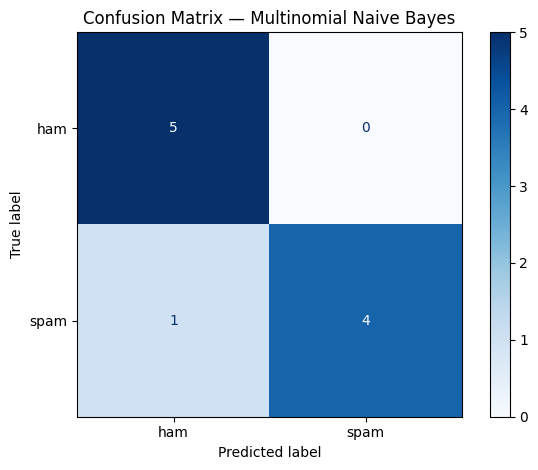

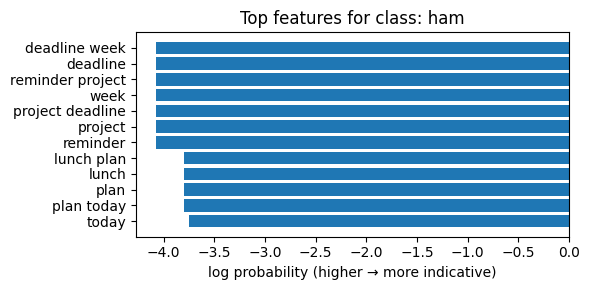

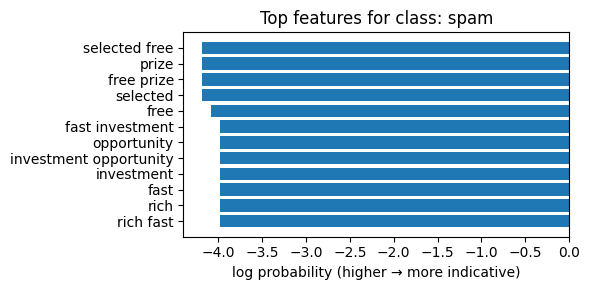

In [23]:
# exp10_naive_bayes_email.py
# Minimal Naive Bayes experiment for email classification (spam/ham or multi-class)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 0. Load dataset (local file)
# ----------------------------
# Expected columns: 'text' and 'label'. Modify if your file uses different names.
df = pd.read_csv("emails.csv")    # place the faculty file named emails.csv in same folder
print("Loaded shape:", df.shape)
print(df.head(3))

# Basic safety: drop rows with missing text or label
df = df.dropna(subset=["text", "label"]).reset_index(drop=True)

# If labels are strings like 'spam'/'ham', that's fine. If numeric, also fine.
X = df["text"].astype(str)
y = df["label"]

# ----------------------------
# 1. Train / Test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# 2. Vectorize text (TF-IDF)
# ----------------------------
# Use basic english stop words from sklearn (no external downloads).
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

# ----------------------------
# 3. Train Multinomial Naive Bayes
# ----------------------------
clf = MultinomialNB(alpha=1.0)
clf.fit(Xtr, y_train)

# ----------------------------
# 4. Predict & Metrics
# ----------------------------
y_pred = clf.predict(Xte)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
# for binary/multiclass use macro averaging for precision/recall/f1
print("Precision (macro):", round(precision_score(y_test, y_pred, average="macro"), 4))
print("Recall (macro):", round(recall_score(y_test, y_pred, average="macro"), 4))
print("F1 (macro):", round(f1_score(y_test, y_pred, average="macro"), 4))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# Save predictions for submission
pd.DataFrame({"text": X_test, "true": y_test, "pred": y_pred}).to_csv("exp10_predictions.csv", index=False)
print("Saved predictions -> exp10_predictions.csv")

# ----------------------------
# 5. Plot 1 — Confusion Matrix (essential)
# ----------------------------
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix — Multinomial Naive Bayes")
plt.tight_layout()
plt.show()

# ----------------------------
# 6. Plot 2 — Top features per class (interpretable)
# ----------------------------
# This works for binary + multiclass. For MultinomialNB, use class log-probabilities.
feature_names = np.array(tfidf.get_feature_names_out())
if hasattr(clf, "feature_log_prob_"):
    # feature_log_prob_.shape = (n_classes, n_features)
    for i, class_label in enumerate(clf.classes_):
        top_n = 12
        top_indices = np.argsort(clf.feature_log_prob_[i])[::-1][:top_n]
        top_feats = feature_names[top_indices]
        top_scores = clf.feature_log_prob_[i][top_indices]

        plt.figure(figsize=(6,3))
        plt.barh(np.arange(top_n)[::-1], top_scores[::-1])
        plt.yticks(np.arange(top_n)[::-1], top_feats[::-1])
        plt.title(f"Top features for class: {class_label}")
        plt.xlabel("log probability (higher → more indicative)")
        plt.tight_layout()
        plt.show()
else:
    print("Model has no feature_log_prob_ attribute; skipping top-features plot.")

# ----------------------------
# Notes:
# - If data is large, reduce max_features in TfidfVectorizer.
# - Use alpha smoothing in MultinomialNB (alpha=1 default). Try alpha=0.5, 0.1 if needed.
# - For text preprocessing customization (stemming, lemmatization), you can preprocess X before vectorizing.
# ----------------------------
